# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


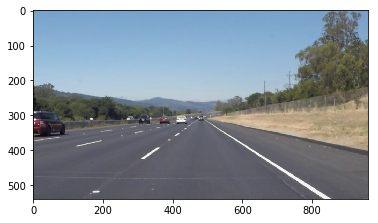

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

### Working against test images
#### Peak on testing images.
Testing images were first examined to see what features they have and whether they are of uniform size. The sizes are expected to be the same for all images since a vehicle will be recording with the same recording device.

Image size of  solidWhiteCurve.jpg is  (540, 960, 3)
Image size of  solidWhiteRight.jpg is  (540, 960, 3)
Image size of  solidYellowCurve.jpg is  (540, 960, 3)
Image size of  solidYellowCurve2.jpg is  (540, 960, 3)
Image size of  solidYellowLeft.jpg is  (540, 960, 3)
Image size of  whiteCarLaneSwitch.jpg is  (540, 960, 3)


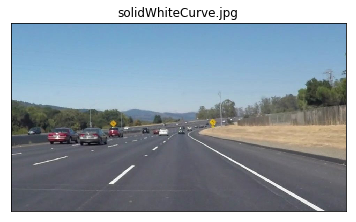

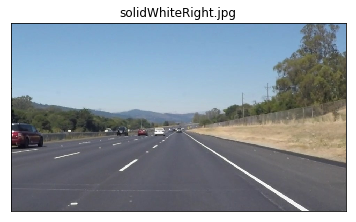

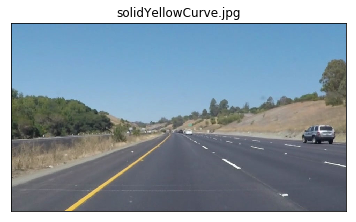

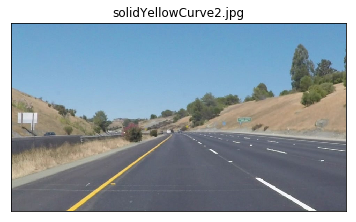

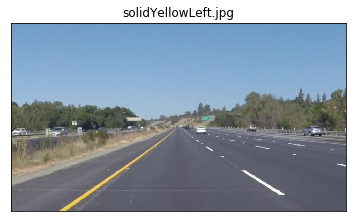

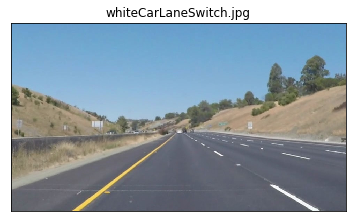

In [5]:
img_list = os.listdir("test_images/")

for img_name in img_list:
    img = mpimg.imread('test_images/' + img_name)
    print('Image size of ',img_name, 'is ', img.shape)
    
    # Plot images to get an idea of what they look like
    
    plt.figure()
    plt.imshow(img)
    plt.xticks([]); plt.yticks([])
    plt.title(img_name)

All images seem relatively the same (dark gray road with yellow/white lanes and a blue sky).
As expected, sizes of the images were the same.

#### Experimenting with Color Selection (Not used for lane detection. Left just for reference.)
Filtering out target objects by colors will enhance the lane detection process. The testing images above show that yellow and white are two main colors of lanes. Since the two colors cannot be detected simultaneously, they will have be filtered out with two separate filters.

Having only maximum thresholds suffice for filtering out white color.  
Filtering out yellow can be done by having minimum and maximum thresholds. 
reference: [Distinguishing colors of Gameboy catridges](http://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/)


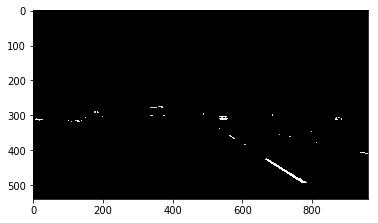

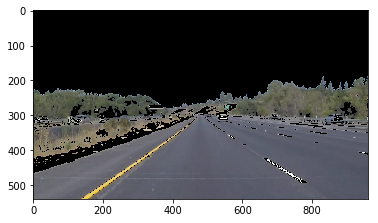

In [6]:
# Parameters for Color Selection
white_filter_threshold = [200, 200, 200]
yellow_filter_threshold = [[25, 146, 190], [62, 174, 250]]

# Read image file - solidYellowLeft.jpg
image = mpimg.imread('test_images/solidYellowLeft.jpg')

def ColorSelection(image):
    white_only = np.copy(image)
    yellow_only = np.copy(image)

    white_thresh = (image[:,:,0] < white_filter_threshold[0]) \
            | (image[:,:,1] < white_filter_threshold[1]) \
            | (image[:,:,2] < white_filter_threshold[2])

    yellow_thresh = ((image[:,:,0] > yellow_filter_threshold[0][0]) \
            & (image[:,:,0] < yellow_filter_threshold[1][0])) \
            | ((image[:,:,1] > yellow_filter_threshold[0][1]) \
            & (image[:,:,1] < yellow_filter_threshold[1][1])) \
            | ((image[:,:,2] > yellow_filter_threshold[0][2]) \
            & (image[:,:,2] < yellow_filter_threshold[1][2]))

    white_only[white_thresh] = [0,0,0]
    yellow_only[yellow_thresh] = [0,0,0]
    
    return [white_only, yellow_only]
    
white, yellow = ColorSelection(image)
plt.imshow(white)
plt.figure()
plt.imshow(yellow)

#### Experimenting with Masking  
Separating a subarea of an image with useful information can enhance lane detection process. The testing images above show that working with a trapezoid shaped mask that sits in the lower 1/3 of image will (hypothetically) work the best for lane detection. 

Test images have height of 540 and width of 960 



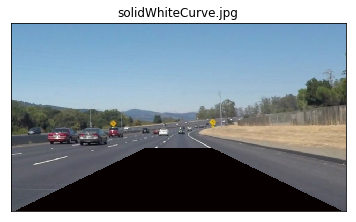

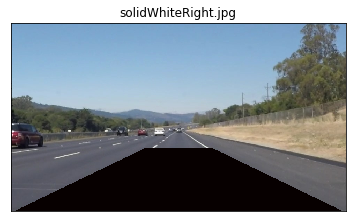

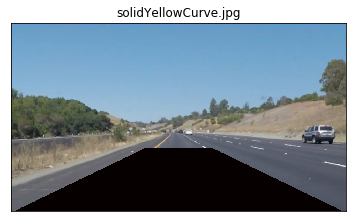

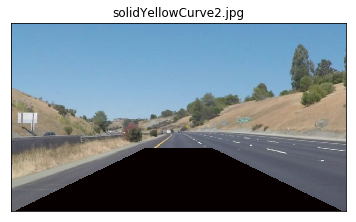

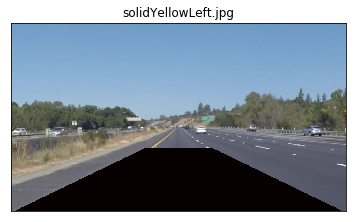

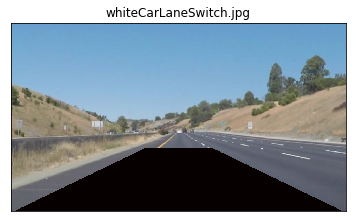

In [7]:
# Check the image dimensions.
img_list = os.listdir("test_images/")
sample_img = mpimg.imread('test_images/' + img_list[0])
height, width, depth = sample_img.shape
print('Test images have height of', height, 'and width of', width, '\n')

# Create mask 
ignore_mask_color = 255   
imshape = image.shape

top_left = (width/2 - width/10 , (2*height)/3)
top_right = (width/2 + width/10, (2*height)/3)
bottom_left = (10, height)
bottom_right = (width - 10 , height)

vertices = np.array([[top_right, top_left, bottom_left, bottom_right]], dtype=np.int32)

# Apply trapezoid shaped mask to every image
for img_name in img_list:
    
    # Read image file
    image = mpimg.imread('test_images/' + img_name)

    third_height = int((2*height)/3)
    cv2.fillPoly(image, vertices , 7)

    plt.figure()
    plt.imshow(image)
    plt.xticks([]); plt.yticks([])
    plt.title(img_name)

The single trapezoid mask generated seems to fit well all testing images available.  
Now, the mask will be used to process images for lane detection.  
Images will go through:
Gray Scaling > Gaussian Smoothing > Canny Edge Detection > Hough Transformation

A helper function `group_lines` takes as inputs detected `lines` information, clusters them by slopes (negative or positive), then outputs a single line per cluster that best represents the cluster.

shape (540, 960, 3)


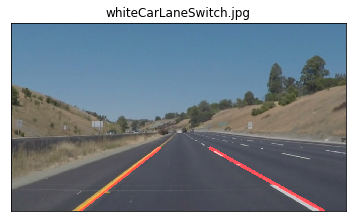

In [8]:
# Initialize line_image
line_image = np.copy(image)*0 

# Parameter for Gaussian Smoothing
kernel_size = 5

# Parameters for Canny Edge Detection
low_threshold = 50
high_threshold = 150

# Parameters for Hough Transformation
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 3    # minimum number of votes (intersections in Hough grid cell)
min_line_length = 12 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments

# Helper function: group_lines(slopes)
# This will cluster slopes into two similar groups and output two lines, one representing each group.
def group_lines(lines):
    slopes = []
    coords = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            slopes.append(slope)
            coords.append([x1, y1])
    
    grp1_slopes = []; grp2_slopes = []
    grp1_coords = []; grp2_coords = []
    
    for idx, slope in enumerate(slopes):
        if slope > 0 :
            grp1_slopes.append(slope)
            grp1_coords.append(coords[idx])
        elif slope < 0:
            grp2_slopes.append(slope)
            grp2_coords.append(coords[idx])
            
    x_grp1, y_grp1 = grp1_coords[0]
    x_grp2, y_grp2 = grp2_coords[0]
    
    slope_grp1 = np.mean(grp1_slopes)
    slope_grp2 = np.mean(grp2_slopes)
    
    # from known slope and a point, calculate the other point on line
    new_grp1_coords = [int(round((height-y_grp1)/slope_grp1+x_grp1)), height, int(round((2*height/3-y_grp1)/slope_grp1+x_grp1)), int(round(2*height/3))]
    new_grp2_coords = [int(round((height-y_grp2)/slope_grp2+x_grp2)), height, int(round((2*height/3-y_grp2)/slope_grp2+x_grp2)), int(round(2*height/3))]
    
    return np.array([[new_grp1_coords], [new_grp2_coords]], dtype=np.int32)
    

image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
 
image_work = np.copy(image)

# GrayScale
gray = cv2.cvtColor(image_work,cv2.COLOR_RGB2GRAY)


# Gaussian Blur
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)


# Canny Edge Detection
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)


# Masking with four sided polygon
mask = np.zeros_like(edges)   
ignore_mask_color = 255 

imshape = image.shape
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)


# Hough Transformation
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)


# Implement the helper function here!
new_lines = []
new_lines = group_lines(lines)

for line in new_lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

        
# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 


# Draw the lines on the edge image
lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 


plt.figure()
plt.imshow(lines_edges)
plt.xticks([]); plt.yticks([])
plt.title(img_name)

print('shape', lines_edges.shape)

Apply GrayScale > GaussianBlur > CannyEdgeDetection

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    image_work = np.copy(image)

    # GrayScale
    gray = cv2.cvtColor(image_work,cv2.COLOR_RGB2GRAY)


    # Gaussian Blur
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)


    # Canny Edge Detection
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)


    # Masking with four sided polygon
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255 

    imshape = image.shape
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)


    # Hough Transformation
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Implement the helper function here!
    new_lines = group_lines(lines)

    for line in new_lines:
        print(line)
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)


    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 


    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    result = lines_edges
    return result

Let's try the one with the solid white lane on the right first ...

In [18]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

TypeError: 'float' object cannot be interpreted as an integer

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [20]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

TypeError: 'float' object cannot be interpreted as an integer

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

This code was written under a few assumptions, which can also be limitations in implementing this code:  
First, there are always two lanes recorded; one positive sloped (located on the left hand side) and one negative (located on the right hand side). The clustering of detected lines by their slopes will fail if the car attempts to change lanes, in which case there can be more than two lanes appearing with different slopes.  
Second, car drives on the road where lanes are clearly distinguishable. The examples provided have good quality lanes which can easily be detected by their colors. However, this will not be always the case.  
Third, car drives on a relatively flat and smooth road. The trapezoid mask did not have to be modified because the car  drove on a relatively flat and smooth road. If the car were to drive on a hilly road, the portion of road and angles of lanes apprearing on the video will change. 

I believe there will be many more conditions in which this code will fail to work. However, I believe I now have a good understanding on what methods and theories to implement for coding lane detection. Moreover, I am very glad to be a part of the Self Driving Car Nanodegree! In the near future, I would like to tune some parameters more, get some insights from other colleagues' works, and make some improvements to the current code. I also look forward to working on the Optional Challenge (which when I tried out with the current code looks like a battle scene from Star Wars...).


Thank you very much for reading.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [22]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

TypeError: 'float' object cannot be interpreted as an integer

In [69]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))